In [1]:
import numpy as np
import math
from functools import reduce
import time
import sys
import os
import numpy as np

path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)
from pathlib import Path
import nidaqmx

def lcm(a, b):
    """Calculate the least common multiple of two numbers."""
    return abs(a * b) // math.gcd(a, b)


def lcm_of_list(numbers):
    """Find the LCM of a list of numbers."""
    return reduce(lcm, numbers)

def seqtime(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])

# some constants
Hz = 1e-9 # GHz
kHz = 1e-6 # GHz
MHz = 1e-3 # GHz
pi = np.pi


In [2]:
import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
from nidaqmx.stream_readers import AnalogSingleChannelReader

from hardware import config_custom as hcf
from hardware.hardwaremanager import HardwareManager
from hardware.pulser.pulser import (
    OutputState,
    TriggerStart,
    TriggerRearm,
    HIGH,
    LOW,
    INF,
    REPEAT_INFINITELY
)
timebase = lcm_of_list(
    [hcf.VDISYN_timebase, hcf.SIDIG_timebase, hcf.PS_timebase, hcf.RSRF_timebase]
)

hm = HardwareManager()
# adds synthesizer, laser, and pulse generator 
hm.add_default_hardware()


VDI Sythesizer Serail Port Open
Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
Clock mode set to: 32
1: Internal, 2: Quartz, 3: External, 32: Direct External Sampling


In [22]:
from pylablib.devices import Thorlabs
cam_addr=Thorlabs.list_cameras_tlcam()[0]
cam_addr
cam = Thorlabs.ThorlabsTLCamera(serial=cam_addr)


In [23]:
import pylablib as pll
from pylablib.devices import Thorlabs
import cv2
import numpy as np

# Initialize the camera (connect to the first available Thorlabs TLCamera)
# cam = Thorlabs.ThorlabsTLCamera()

try:
    # Get the maximum ROI (full sensor size)
    max_width, max_hqeight = cam.get_detector_size()
    cam.set_roi(0, max_width, 0, max_height)  # Set ROI to full sensor

    # Optimize for speed: minimize exposure time and maximize frame rate
    cam.set_exposure(1E-3)  # Set exposure to 1 ms (adjust if too dark/bright)
    # Note: Frame rate is limited by exposure time and readout speed

    # Start acquisition in continuous mode
    cam.start_acquisition()

    print("Press 'q' to quit the live video feed.")
    
    while True:
        # Read the oldest available frame as fast as possible
        frame = cam.read_oldest_image()  # Get one frame from the buffer
        if frame is None:
            continue  # Skip if no frame is available yet

        # Convert frame to uint8 for OpenCV display (assuming monochrome or RGB)
        if frame.ndim == 3:  # Color camera (RGB)
            frame_displayq = np.clip(frame, 0, 255).astype(np.uint8)
        else:  # Monochrome camera
            frame_display = np.clip(frame / frame.max() * 255, 0, 255).astype(np.uint8)

        # Display the frame
        cv2.imshow("Thorlabs Camera Live Feed", frame_display)

        # Check for 'q' key to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    # Clean up: stop acquisition and close the camera
    cam.stop_acquisition()
    cam.close()
    cv2.destroyAllWindows()

print("Camera closed and window terminated.")

Press 'q' to quit the live video feed.


KeyboardInterrupt: 

In [3]:
import pylablib as pll
pll.par["devices/dlls/thorlabs_tlcam"] = "path/to/dlls"
from pylablib.devices import Thorlabs
cam = Thorlabs.ThorlabsTLCamera()

In [20]:
from pylablib.devices import Thorlabs
cam_addr=Thorlabs.list_cameras_tlcam()[0]
cam_addr

'23886'

In [6]:
max_width, max_height = cam.get_detector_size()  # Ensure your API supports this
print(f"Maximum detector size: {max_width} x {max_height}")

Maximum detector size: 4096 x 2160


In [7]:
cam1.open()
cam1.set_exposure(0.01)  # Exposure time in seconds
cam1.set_roi(0, max_width, 0, max_height)  # Set ROI (x, y, width, height)

(0, 4096, 0, 2160, 1, 1)

In [8]:
test=cam1.snap()

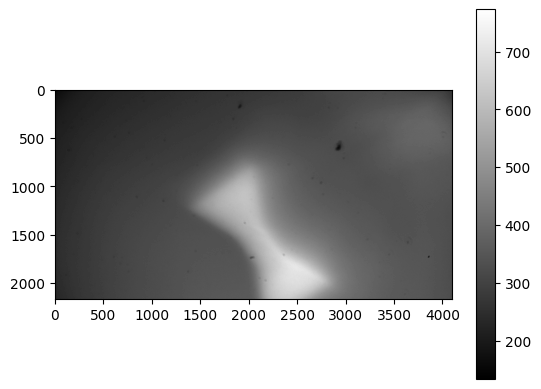

In [9]:
import matplotlib.pyplot as plt
image_array = np.array(test)
plt.imshow(image_array, cmap='gray')
plt.colorbar()
# plt.title(idx)
plt.show()

In [15]:
import numpy as np
import plotly.graph_objects as go
import time
from IPython.display import display, clear_output

# Open camera
cam1.open()

# Apply optimized settings
cam1.set_device_variable("exposure", 0.02)
cam1.set_device_variable("roi", (0, 512, 0, 512, 1, 1))
cam1.set_device_variable("trigger_mode", "int")
cam1.set_device_variable("hotpixel_correction", (0, 0))
cam1.set_device_variable("frame_period", 0.005)

# Start acquisition with buffer
cam1.setup_acquisition(nframes=100)
cam1.start_acquisition()

# Initialize figure with dummy array if no frame yet
frame = cam1.read_newest_image()
if frame is None:
    image_array = np.zeros((512, 512), dtype=np.uint8)  # Dummy array matching ROI
else:
    image_array = np.array(frame, dtype=np.uint8)
fig = go.Figure(data=[go.Heatmap(
    z=image_array,
    colorscale='gray',
    zmin=0, zmax=255
)])
fig.update_layout(width=400, height=400, margin=dict(l=10, r=10, t=10, b=10))
display(fig)

start_time = time.time()
frame_count = 0
batch_size = 5

# Main loop with batch reading, skipping None frames
while time.time() - start_time < 15:
    frames = cam1.read_multiple_images(nframes=batch_size)
    for frame in frames:
        if frame is not None:  # Skip if no frame
            image_array = np.array(frame, dtype=np.uint8)
            fig.data[0].z = image_array
            frame_count += 1
            if frame_count % 5 == 0:
                clear_output(wait=True)
                display(fig)
    time.sleep(0.001)

# Cleanup
cam1.stop_acquisition()
cam1.close()

# Print FPS
print(f"FPS: {frame_count / (time.time() - start_time):.2f}")

TypeError: ThorlabsTLCamera.read_multiple_images() got an unexpected keyword argument 'nframes'

In [11]:
cam1.open()
cam1.get_settings()

{'image_indexing': 'rct',
 'frame_format': 'list',
 'frame_info_format': 'namedtuple',
 'frame_info_period': 1,
 'exposure': 0.020006,
 'roi': (0, 512, 0, 512, 1, 1),
 'trigger_mode': 'int',
 'ext_trigger': 'rise',
 'hotpixel_correction': (0, 0),
 'gain': 0.0,
 'black_level': 5,
 'led': 1,
 'color_format': TColorFormat(color_format='raw', color_space='linear'),
 'frame_period': 0.020104}

In [12]:
import numpy as np
import plotly.graph_objects as go
import time
from IPython.display import display, clear_output

# Open and configure the camera
cam1.open()
cam1.set_exposure(0.1)
cam1.set_roi(0, max_width, 0, max_height)
cam1.setup_acquisition()
cam1.start_acquisition()

start_time = time.time()

while time.time() - start_time < 15:
    # cam1.wait_for_frame()
    frame = cam1.read_newest_image()
    image_array = np.array(frame)
    
    # Create and display the image plot
    fig = go.Figure(data=go.Heatmap(z=image_array, colorscale='gray'))
    clear_output(wait=True)
    display(fig)
    
    time.sleep(0.01)  # Reduce delay to speed up updates

cam1.stop_acquisition()
cam1.close()


KeyboardInterrupt: 

In [ ]:
# import numpy as np
# import plotly.graph_objects as go
# import time
# import keyboard
# from IPython.display import display, clear_output

# # Open and configure the camera
# cam1.open()
# cam1.set_exposure(0.1)
# cam1.set_roi(0, max_width, 0, max_height)
# cam1.setup_acquisition()
# cam1.start_acquisition()

# print("Press 'q' to stop the loop.")

# while True:
#     if keyboard.is_pressed('q'):
#         print("Stopping acquisition...")
#         break
    
#     cam1.wait_for_frame()
#     frame = cam1.read_newest_image()
#     image_array = np.array(frame)
    
#     # Create and display the image plot
#     fig = go.Figure(data=go.Heatmap(z=image_array, colorscale='gray'))
#     clear_output(wait=True)
#     display(fig)
    
#     time.sleep(0.05)  # Reduce delay to speed up updates

# cam1.stop_acquisition()
# cam1.close()


: 

: 

: 

: 

: 

In [ ]:
# import numpy as np
# import plotly.graph_objects as go
# import time
# from IPython.display import display, clear_output

# # Open and configure the camera
# cam1.open()
# cam1.set_exposure(0.1)
# cam1.set_roi(0, max_width, 0, max_height)
# cam1.setup_acquisition()
# cam1.start_acquisition()

# start_time = time.time()

# while time.time() - start_time < 100:
#     cam1.wait_for_frame()
#     frame = cam1.read_newest_image()
#     image_array = np.array(frame)
    
#     # Create and display the image plot
#     fig = go.Figure(data=go.Heatmap(z=image_array))
#     clear_output(wait=True)
#     display(fig)

# cam1.stop_acquisition()
# cam1.close()


: 

: 

: 

: 

: 

In [ ]:
cam1.open()
cam1.get_frames_status()

TFramesStatus(acquired=0, unread=0, skipped=0, buffer_size=0)

: 

: 

: 

: 

: 

In [ ]:
# # import matplotlib.pyplot as plt
# import numpy as np
# import time

# # Open and configure the camera
# cam1.open()
# cam1.set_exposure(0.1)
# cam1.set_roi(0, max_width, 0, max_height)
# cam1.setup_acquisition()
# cam1.start_acquisition()

# # Matplotlib setup
# plt.ion()
# fig, ax = plt.subplots()
# initial_frame = np.zeros((max_height, max_width))  # Initialize with zeros
# img = ax.imshow(initial_frame, cmap='gray', vmin=0, vmax=255)  # Set min/max for consistency
# cb = plt.colorbar(img, ax=ax)
# plt.show()

# idx = 0
# start_time = time.time()

# while time.time() - start_time < 5:
#     cam1.wait_for_frame()
#     frame = cam1.read_newest_image()

#     # for i in range(len(frame)):
#     image_array = np.array(frame)

#     #     if image_array is not None and image_array.size > 0:
#     img.set_data(image_array)
#     # img.set_clim(vmin=image_array.min(), vmax=image_array.max())  # Update color scale

#     # Force Matplotlib to refresh without `plt.pause()`
#     fig.canvas.draw()
#     fig.canvas.flush_events()

#     ax.set_title(f"Frame {idx}")
#     idx += 1
# cam1.stop_acquisition()
# cam1.close()


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# cam1.open()
# cam1.set_exposure(.1)
# cam1.set_roi(0, max_width, 0, max_height)
# cam1.setup_acquisition()
# cam1.start_acquisition()

# plt.ion()
# fig, ax = plt.subplots()
# initial_frame = image_array  # Match your ROI
# img = ax.imshow(initial_frame, cmap='gray')
# cb = plt.colorbar(img, ax=ax)
# plt.show()  # Important for interactive mode

# idx = 0
# start_time = time.time()

# while time.time() - start_time <5:
#     cam1.wait_for_frame()
#     frame = cam1.read_multiple_images()
#     for i in range(0,np.shape(frame)[0]):
#         image_array = np.array(frame[i])
#         img.set_data(image_array)
#         img.set_clim(vmin=image_array.min(), vmax=image_array.max())
#         cb.update_normal(img)
#         ax.set_title(f"Frame {idx}")
#         plt.pause(.001)
#         print(idx)

# cam1.close()

: 

: 

: 

: 

: 

In [ ]:
np.shape(frame)[0]

2160

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

NameError: name 'idx' is not defined

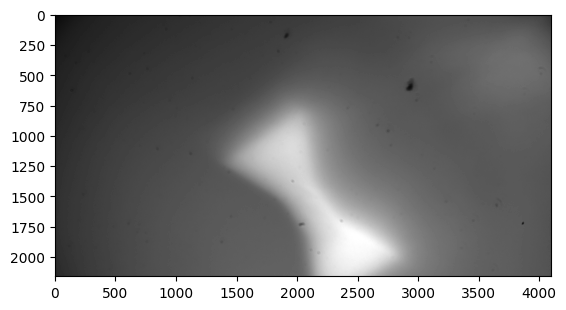

: 

: 

: 

: 

: 

In [ ]:
import matplotlib.pyplot as plt
image_array = np.array(frame)
plt.imshow(image_array, cmap='gray')
# plt.colorbar()
plt.title(idx)
plt.show()

In [ ]:
cam1.close()

: 

: 

: 

: 

: 

In [ ]:
# import matplotlib.pyplot as plt
# cam1.open()
# cam1.set_exposure(0.01)  # Exposure time in seconds
# cam1.set_roi(0, max_width, 0, max_height)  # Set ROI (x, y, width, height)
# cam1.setup_acquisition()
# cam1.start_acquisition()
# idx=1
# frame=None
# while True:
#     frame=cam1.read_oldest_image()
#     if frame is not None:
#         idx+=1
#         image_array = np.array(frame)
#         plt.imshow(image_array, cmap='gray')
#         # plt.colorbar()
#         plt.title(idx)
#         plt.show()
#         frame=None
# #     cam1.wait_for_frame()
# #     frame=cam.read_oldest_image()

: 

: 

: 

: 

: 

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# cam1.open()
# cam1.set_exposure(0.01)  # Exposure time in seconds
# cam1.set_roi(0, max_width, 0, max_height)  # Set ROI (x, y, width, height)
# cam1.setup_acquisition()
# cam1.start_acquisition()

# plt.ion()  # Turn on interactive mode
# fig, ax = plt.subplots()
# im = ax.imshow(np.zeros((max_height, max_width)), cmap='gray')  # Initial empty image
# cbar = plt.colorbar(im, ax=ax)

# idx = 1
# while True:
#     frame = cam1.read_oldest_image()
#     if frame is not None:
#         idx += 1
#         image_array = np.array(frame)
#         im.set_data(image_array)
#         im.set_clim(vmin=image_array.min(), vmax=image_array.max())  # Update color scale
#         ax.set_title(f"Frame {idx}")
#         plt.pause(0.001)  # Small pause to allow update


: 

: 

: 

: 

: 

In [ ]:
# import time
# import numpy as np
# import matplotlib.pyplot as plt

# cam1.open()
# cam1.set_exposure(0.01)  # Exposure time in seconds
# cam1.set_roi(0, max_width, 0, max_height)  # Set ROI (x, y, width, height)

# plt.ion()  # Enable interactive mode
# fig, ax = plt.subplots()
# img_display = ax.imshow(np.zeros((max_height, max_width)), cmap='gray', vmin=0, vmax=255)
# plt.colorbar(img_display, ax=ax)
# plt.title("Thorlabs Camera Live Capture")

# try:
#     while True:
#         image = cam1.snap()
#         image_array = np.array(image)

#         img_display.set_data(image_array)
#         plt.draw()
#         plt.pause(3)  # Pause for 0.1 seconds

# except KeyboardInterrupt:
#     print("Stopped by user.")

# cam1.close()
# plt.ioff()
# plt.show()


: 

: 

: 

: 

: 